<a href="https://colab.research.google.com/github/Srijan2001/Keypoint-regression/blob/master/Keypoint_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from math import *

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, ZeroPadding2D, Add
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.layers import Input, Activation
from keras.models import Model
import keras.applications.resnet

import tensorflow as tf
from tensorflow.keras import initializers, regularizers
from keras.regularizers import l2
from keras.initializers import glorot_uniform


In [2]:
labels = pd.read_csv('/content/rektnet-training_rektnet_label.csv')
y_cols = ['top','mid_L_top','mid_R_top','mid_L_bot','mid_R_bot','bot_L','bot_R']
labels['Id'] = range(1,len(labels)+1)
#converting strings to lists
from ast import literal_eval
for columns in labels[y_cols]:
    for i in range(len(labels)):
        labels[columns][i] = literal_eval(labels[columns][i])

Y_train,Y_test = train_test_split(labels,test_size = 0.2,random_state=0)    #Y_train is 2557 X 11 
labels.head()                                                        #Y_test is 640 X 11
batch_size=16
input_shape = (80,80,3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
def load_images(folder):        # OpenCV reads images in BRG format but Matplotlib reads it in RBG.
    images_train = []
    images_test = []
    original_res_train = []
    original_res_test = []
    
    for filename in Y_train['Unnamed: 0']:
        img = cv2.imread(os.path.join(folder,str(filename)))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        if img is not None:
            images_train.append(img)
            original_res_train.append(list(img.shape))
   
    for filename in Y_test['Unnamed: 0']:
        img = cv2.imread(os.path.join(folder,str(filename)))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        if img is not None:
            images_test.append(img)
            original_res_test.append(list(img.shape))

            
            
    return images_train,images_test,original_res_train,original_res_test


In [4]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!unzip '/content/gdrive/My Drive/RektNet_Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: RektNet_Dataset/vid_37_frame_324_2.jpg  
  inflating: RektNet_Dataset/vid_31_frame_3079_17.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2494_0.jpg  
  inflating: RektNet_Dataset/vid_42_frame_378_6.jpg  
  inflating: RektNet_Dataset/vid_5_frame_1938_6.jpg  
  inflating: RektNet_Dataset/vid_18_frame_1908_0.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2757_1.jpg  
  inflating: RektNet_Dataset/vid_40_frame_259_23.jpg  
  inflating: RektNet_Dataset/vid_31_frame_1950_3.jpg  
  inflating: RektNet_Dataset/vid_28_frame_1930_4.jpg  
  inflating: RektNet_Dataset/vid_31_frame_2533_7.jpg  
  inflating: RektNet_Dataset/vid_71_frame_45_4.jpg  
  inflating: RektNet_Dataset/vid_30_frame_1501_0.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2497_12.jpg  
  inflating: RektNet_Dataset/vid_101_frame_222_18.jpg  
  inflating: RektNet_Dataset/vid_42_frame_840_3.jpg  
  inflating: RektNet_Dataset/vid_5_frame_2347_0.jpg  
  inflating: RektNet

In [6]:

images_train,images_test,images_train_shape,images_test_shape = load_images('/content/RektNet_Dataset')
images_train = np.array(images_train)
images_test = np.array(images_test)
print(images_train_shape)


[[45, 31, 3], [75, 74, 3], [80, 63, 3], [31, 25, 3], [60, 35, 3], [49, 37, 3], [72, 56, 3], [46, 30, 3], [63, 52, 3], [67, 51, 3], [38, 26, 3], [57, 35, 3], [123, 104, 3], [35, 25, 3], [67, 43, 3], [41, 33, 3], [88, 56, 3], [53, 30, 3], [55, 45, 3], [36, 25, 3], [73, 51, 3], [49, 40, 3], [41, 26, 3], [57, 34, 3], [46, 35, 3], [63, 49, 3], [86, 77, 3], [55, 41, 3], [89, 64, 3], [41, 32, 3], [49, 34, 3], [37, 20, 3], [67, 52, 3], [88, 75, 3], [43, 33, 3], [65, 59, 3], [89, 64, 3], [60, 41, 3], [78, 65, 3], [54, 28, 3], [60, 49, 3], [71, 47, 3], [42, 31, 3], [63, 53, 3], [83, 85, 3], [31, 27, 3], [101, 69, 3], [51, 37, 3], [33, 26, 3], [85, 73, 3], [39, 29, 3], [36, 20, 3], [73, 52, 3], [48, 33, 3], [66, 51, 3], [36, 30, 3], [54, 41, 3], [82, 81, 3], [65, 51, 3], [40, 31, 3], [43, 27, 3], [85, 60, 3], [31, 18, 3], [70, 50, 3], [53, 37, 3], [53, 42, 3], [54, 38, 3], [98, 70, 3], [50, 35, 3], [45, 27, 3], [44, 38, 3], [50, 42, 3], [71, 56, 3], [46, 29, 3], [88, 67, 3], [33, 23, 3], [51, 31,

In [7]:
def create_labels_array():
    labels_k_train = []
    labels_k_test = []

    for i in Y_train['Id']:
        k = []
        for j in Y_train[y_cols]:
            k.append(Y_train[j][i-1])
        k = np.array(k)
        k = k.reshape(1,14)
        labels_k_train.append(k)
        
    for i in Y_test['Id']:
        k = []
        for j in Y_test[y_cols]:
            k.append(Y_test[j][i-1])
        k = np.array(k)
        k = k.reshape(1,14)
        labels_k_test.append(k)
            

    labels_k_train = np.array(labels_k_train)
    Y_train_labels = labels_k_train.reshape(len(Y_train),14)
    
    labels_k_test = np.array(labels_k_test)
    Y_test_labels = labels_k_test.reshape(len(Y_test),14)
    
    Y_train_labels = Y_train_labels.astype('float')
    Y_test_labels = Y_test_labels.astype('float')
    
    return Y_train_labels,Y_test_labels


In [8]:
Y_train_labels,Y_test_labels = create_labels_array()    # Y_train_labels is 2557 X 14
print(Y_train_labels)         # Y_test_labels is 640 X 14

[[13.  1.  8. ... 37. 25. 35.]
 [17.  3. 14. ... 58. 53. 41.]
 [28.  4. 20. ... 67. 50. 64.]
 ...
 [20.  3. 12. ... 25. 21. 28.]
 [26.  8. 14. ... 50. 30. 55.]
 [13.  2.  8. ... 29. 19. 29.]]


[[25.  0.]
 [15. 14.]
 [28. 16.]
 [10. 28.]
 [29. 31.]
 [ 7. 36.]
 [29. 39.]]


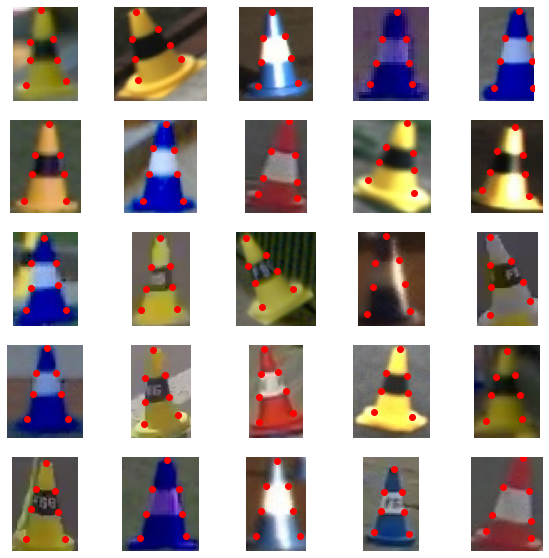

In [9]:
plt.figure(figsize =(10,10))
for n in range(25):
    ax = plt.subplot(5,5,n+1)
    points = Y_train_labels[n].reshape(7,2)
    plt.plot(points[:,0],points[:,1],'ro')
    plt.imshow(images_train[n])
    plt.axis('off')
print(points)


[[ 6.  3.]
 [ 3. 16.]
 [14. 13.]
 [ 4. 27.]
 [19. 23.]
 [ 5. 40.]
 [24. 35.]]


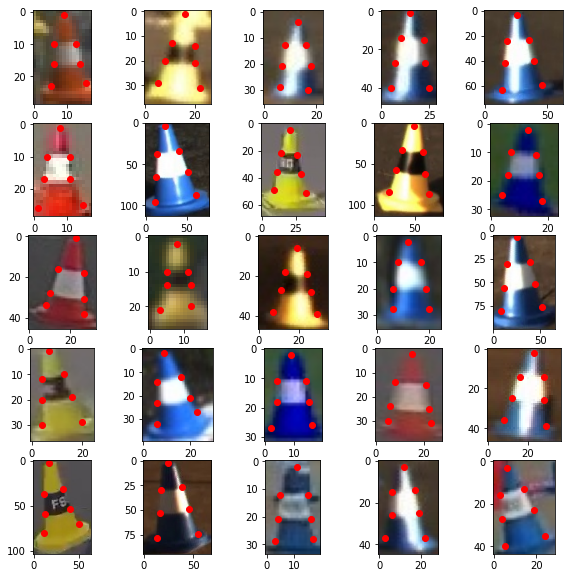

In [10]:
plt.figure(figsize =(10,10))                      #Displaying the test dataset
for n in range(25):
    ax = plt.subplot(5,5,n+1)
    points = Y_test_labels[n].reshape(7,2)
    plt.plot(points[:,0],points[:,1],'ro')
    plt.imshow(images_test[n])
    #plt.axis('off')
print(points)

In [11]:
def rescale(img_train,img_test,Y_train,orig_train,Y_test,orig_test,new_img_size):
    
    train = []
    X_train_imgs = np.empty([len(img_train),new_img_size,new_img_size,3])
    for i in range(len(Y_train)):
        img_train[i] = cv2.resize(img_train[i],dsize=(new_img_size,new_img_size),interpolation = cv2.INTER_CUBIC)
        train.append(img_train)
        orig_train_x = orig_train[i][0]
        orig_train_y = orig_train[i][1]
        
        scale_y = new_img_size/orig_train_y
        scale_x = new_img_size/orig_train_x
        
        train_example = Y_train[i].reshape(7,2)
        train_example[:,0] = train_example[:,0]*scale_y
        train_example[:,1] = train_example[:,1]*scale_x
        train_example = train_example.reshape(1,14)
        Y_train[i] = train_example
        
        X_train_imgs[i] = img_train[i]
    
    X_test_imgs = np.empty([len(img_test),new_img_size,new_img_size,3])
    for i in range(len(Y_test)):
        
        img_test[i] = cv2.resize(img_test[i],dsize=(new_img_size,new_img_size),interpolation = cv2.INTER_CUBIC)
        orig_test_x = orig_test[i][0]
        orig_test_y = orig_test[i][1]
        
        scale_test_x = new_img_size/orig_test_x
        scale_test_y = new_img_size/orig_test_y

        test_example = Y_test[i].reshape(7,2)
        test_example[:,0] = test_example[:,0]*scale_test_y
        test_example[:,1] = test_example[:,1]*scale_test_x
        test_example = test_example.reshape(1,14)
        Y_test[i] = test_example
        
        X_test_imgs[i] = img_test[i]
        
    return X_train_imgs, X_test_imgs, Y_train,Y_test


In [12]:
X_train_imgs,X_test_imgs,Y_train,Y_test = rescale(images_train,images_test,Y_train_labels,images_train_shape,Y_test_labels,images_test_shape,80)

In [13]:
X_train = X_train_imgs.astype('float')/255
X_test = X_test_imgs.astype('float')/255
print("X_train_shape :",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("Y_train_shape :", Y_train.shape)
print("Y_test_shape :",Y_test.shape)

X_train_shape : (2557, 80, 80, 3)
X_test_shape :  (640, 80, 80, 3)
Y_train_shape : (2557, 14)
Y_test_shape : (640, 14)


In [14]:
def ratio_left(A):
   P13 = K.sqrt(K.square(A[:,0]-A[:,6]) + K.square(A[:,1]-A[:,7]))
   P14 = K.sqrt(K.square(A[:,0]-A[:,10]) + K.square(A[:,1]-A[:,11]))
   P23 = K.sqrt(K.square(A[:,2]-A[:,6]) + K.square(A[:,3]-A[:,7]))
   P24 = K.sqrt(K.square(A[:,2]-A[:,10]) + K.square(A[:,3]-A[:,11]))
   Cr1234 = float(P13/P14)/(P23/P24)
   return Cr1234              #Shape is batch_size X 1

In [15]:
def ratio_right(A):
   P16 = K.sqrt(K.square(A[:,0]-A[:,8]) + K.square(A[:,1]-A[:,9]))
   P17 = K.sqrt(K.square(A[:,0]-A[:,12]) + K.square(A[:,1]-A[:,13]))
   P56 = K.sqrt(K.square(A[:,4]-A[:,8]) + K.square(A[:,5]-A[:,9]))
   P57 = K.sqrt(K.square(A[:,4]-A[:,12]) + K.square(A[:,5]-A[:,13]))
   Cr1567 = float(P16/P17)/(P56/P57)
   return Cr1567              #Shape is batch_size X 1

In [16]:
"""def cross_ratio_loss(y_true,y_pred):
  #Shape of y_true and y_pred should be [batch_size,14]
  #loss should be a vector of length batch_size as we have to return the loss for each datapoint
  #y_true = y_true.reshape([batch_size,14])
  #y_pred = y_pred.reshape([batch_size,14])
  loss = np.array([])
  temp = 0
  
  for i in range(0, 20):
      P13 = sqrt((y_pred[i][0]-y_pred[i][6])**2 + (y_pred[i][1]-y_pred[i][7])**2)
      P14 = sqrt((y_pred[i][0]-y_pred[i][10])**2 + (y_pred[i][1]-y_pred[i][11])**2)
      P23 = sqrt((y_pred[i][2]-y_pred[i][6])**2 + (y_pred[i][3]-y_pred[i][7])**2)
      P24 = sqrt((y_pred[i][2]-y_pred[i][10])**2 + (y_pred[i][3]-y_pred[i][11])**2)
      Cr1234 = (P13/P14)/(P23/P24)
      P16 = sqrt((y_pred[i][0]-y_pred[i][8])**2 + (y_pred[i][1]-y_pred[i][9])**2)
      P17 = sqrt((y_pred[i][0]-y_pred[i][12])**2 + (y_pred[i][1]-y_pred[i][13])**2)
      P56 = sqrt((y_pred[i][4]-y_pred[i][8])**2 + (y_pred[i][5]-y_pred[i][9])**2)
      P57 = sqrt((y_pred[i][4]-y_pred[i][12])**2 + (y_pred[i][5]-y_pred[i][13])**2)
      Cr1567 = (P16/P17)/(P56/P57)
      
      temp = 0.0001*(Cr1234 - 1.4)**2 + 0.0001*(Cr1567 - 1.4)**2
      temp2 = 0

      for j in range(0, 14):
         temp2 += (y_true[i][j] - y_pred[i][j])**2

      loss = np.append(loss, [temp + temp2])
  

  loss = loss.reshape([1,20])
  return loss """

def cross_ratio_loss(y_true,y_pred):        # y_true and y_pred are expected as 
                                             # tensors of size [batch_size,14]
    loss = 0
    loss = K.square(y_true-y_pred)
    loss = K.mean(loss, axis=-1)

    Cr1234 = ratio_left(y_pred)
    Cr1567 = ratio_right(y_pred)
    temp1 = K.mean(K.square(1.4 - Cr1234), axis = -1)          #Shape is batch_size X 1
    temp2 = K.mean(K.square(1.4 - Cr1567), axis = -1)          #Shape is batch_size X 1

    loss += 0.0001*temp1 + 0.0001*temp2
    
    return loss 

  
  


In [17]:
def identity_block(X, C):

    #p1 = ZeroPadding2D((2,2))
    conv1 = Conv2D(C, (3,3) ,strides = (1,1),padding = 'same', dilation_rate = 2,kernel_regularizer = l2(0.01))
    bn1 = BatchNormalization(axis = 3)
    relu1 = Activation('relu')
    
    #p2 = ZeroPadding2D((1,1))
    conv2 = Conv2D(C, (3,3) , strides = (1,1),padding = 'same',kernel_regularizer = l2(0.01))
    bn2 = BatchNormalization(axis = 3)
    relu2 = Activation('relu')
    
    short_cut_conv = Conv2D(C, (1,1), strides = (1,1),kernel_regularizer = l2(0.01))
    short_cut_bn = BatchNormalization(axis = 3)
    
    #p1 = p1(X)
    c1 = conv1(X)
    b1 = bn1(c1)
    a1 = relu1(b1)
    
    #p2 = p2(a1)
    c2 = conv2(a1)
    b2 = bn2(c2)
    a2 = relu2(b2)
    
    short_cut = short_cut_conv(X)
    s_c = short_cut_bn(short_cut)
    
    X = Add()([b2,s_c])

    X = Activation('relu')(X)
    return X

In [18]:
def resnet_model(input_shape):

    initializer = glorot_uniform()
    X_input = Input(input_shape)
  
    X = Conv2D(64, (7,7), strides = (1,1), padding = 'valid',kernel_regularizer=l2(0.01))(X_input)
    
    X = identity_block(X,64)
    X = identity_block(X,64*2)
    X = identity_block(X,64*4)
    X = identity_block(X,64*8)
    X = Flatten()(X)

    #X = Dropout(0.4)(X)
    #X = Dense(64,activation = 'relu', kernel_regularizer = l2(0.01))(X)
    #X = Dropout(0.4)(X)
    #X = Dense(14)(X)

    #X = Dropout(0.4)(X)
    #X = Dense(64, activation = 'relu',kernel_regularizer=l2(0.01))(X)
    X = Dense(14)(X)
    
    model = Model(inputs = X_input,outputs = X, name = 'resnet')
    
    
    return model


In [19]:
model = resnet_model(input_shape)

In [20]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr*exp(-0.1)
  else:
    return lr*0.75

In [21]:
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 64)   256         conv2d_1[0][0]                   
_____________________________________________________________________________________________

In [22]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
lr = 0.00001
optimizer = SGD(lr, momentum = 0.9)
model.compile(optimizer = optimizer,loss = cross_ratio_loss, metrics = [tf.keras.metrics.MeanSquaredError()])

In [23]:
print(Y_train.shape)
print(X_train.shape)

(2557, 14)
(2557, 80, 80, 3)


In [24]:
history = model.fit(X_train,Y_train,validation_split = 0.2, callbacks= [callback], epochs = 20,batch_size = 32)

Epoch 1/20
64/64 [==============================] - 151s 2s/step - loss: 159.6386 - mean_squared_error: 136.7402 - val_loss: 904.7855 - val_mean_squared_error: 881.8828
Epoch 2/20
64/64 [==============================] - 138s 2s/step - loss: 33.9710 - mean_squared_error: 11.0705 - val_loss: 296.4576 - val_mean_squared_error: 273.5594
Epoch 3/20
64/64 [==============================] - 138s 2s/step - loss: 28.6936 - mean_squared_error: 5.7975 - val_loss: 153.7205 - val_mean_squared_error: 130.8266
Epoch 4/20
64/64 [==============================] - 136s 2s/step - loss: 29.5620 - mean_squared_error: 6.6701 - val_loss: 86.8209 - val_mean_squared_error: 63.9309
Epoch 5/20
64/64 [==============================] - 137s 2s/step - loss: 27.8570 - mean_squared_error: 4.9687 - val_loss: 39.1568 - val_mean_squared_error: 16.2703
Epoch 6/20
64/64 [==============================] - 136s 2s/step - loss: 26.0003 - mean_squared_error: 3.1153 - val_loss: 35.2739 - val_mean_squared_error: 12.3906
Epoch 

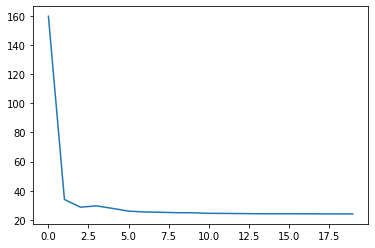

In [25]:
plt.plot(history.history['loss'])

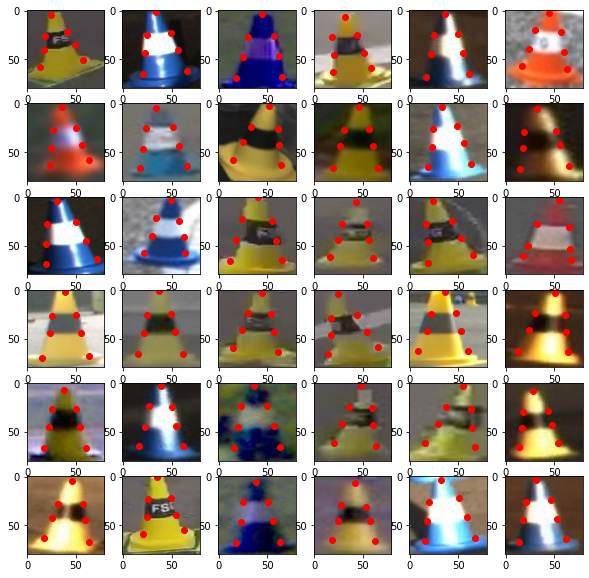

In [31]:
prediction = model.predict(X_test)
plt.figure(figsize=(10,10))
for n in range(36):
  ax = plt.subplot(6,6,n+1)
  points = prediction[n+150].reshape(7,2)
  plt.plot(points[:,0],points[:,1],'ro')
  plt.imshow(X_test_imgs[n+150].astype(np.uint8))
